# Preprocessing and visualization

<div class="warning" style='background-color:lightgreen; color: black; border-left: solid black 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='text-align:left'>
<b>Benchmark:</b> Germain, PL., Sonrel, A. & Robinson, M.D. pipeComp, a general framework for the evaluation of computational pipelines, reveals performant single cell RNA-seq preprocessing tools. Genome Biol 21, 227 (2020). https://doi.org/10.1186/s13059-020-02136-7</p>
</span>
</div>

In this notebook, we start with a raw anndata object and perform some basic quality control, filter out empty droplets and remove droplets that contain more than one cell (doublets).

- TODO: Add text for normalization, feature selection

First, we import some packages that we need and start up rpy2 to use R packages

In [1]:
# put imports here
import anndata2ri
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2.robjects as ro
import scanpy as sc
import seaborn as sns

from functools import partial
from rpy2.ipython import html
from scipy.sparse import issparse

import rpy2.rinterface_lib.callbacks
import logging


In [2]:
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

sc.settings.verbosity = 3
sc.set_figure_params(dpi=100, dpi_save=300)
#sc.logging.print_versions()

In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(Seurat)
library(scater)

library(scDblFinder)  # doublet detection
library(scran) # scran normalization
library(sctransform) # sctransform normalization
library(scry)
#require(scry) # feature selection

## Dataset



The downloaded file can be read by using scanpy to create an AnnData object.

In [4]:
#adata = sc.read('mouse_intestine_raw.h5ad')
adata = sc.read('endocrinogenesis_day15.h5ad')
adata.X = adata.X.toarray()

/Users/anna.schaar/opt/miniconda3/envs/bestprac2_dataprep/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/anna.schaar/opt/miniconda3/envs/bestprac2_dataprep/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [5]:
if issparse(adata.X):
    if not adata.X.has_sorted_indices:
        adata.X.sort_indices()

for key in adata.layers:
    if issparse(adata.layers[key]):
        if not adata.layers[key].has_sorted_indices:
            adata.layers[key].sort_indices()

The dataset contains 13,353 cells and measurements for 27,998 genes. 

## 2.1 Doublet detection

Next, we run scDblFinder to look for droplets that contain more than one cell. Other than most methods, scDblFinder works on raw counts. As scDblFinder is an R package, we use anndata2ri to convert the anndata object to a sce object and back. scDblFinder has been shown to perform very well compared to other methods (CITE pipeComp).

In [6]:
data_mat = adata.copy().X.T

In [7]:
%%R -i data_mat -o classification

sce <- scDblFinder(SingleCellExperiment(list(counts=data_mat)), verbose=TRUE)
classification = sce$scDblFinder.class

In [8]:
adata.obs['scDblFinder_class'] = np.expand_dims(list(classification), axis=1)

Here, scDblFinder identifies 90 droplets as doublets. We remove those droplets from the data

In [9]:
adata.obs['scDblFinder_class'].value_counts()

singlet    3606
doublet      90
Name: scDblFinder_class, dtype: int64

In [10]:
adata = adata[adata.obs['scDblFinder_class']=='singlet'].copy()



<div class="warning" style='background-color:lightgrey; color: black; border-left: solid back 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:left'>
<b>Main take-aways</b></p>
<p style='margin-left:1em;'>

</p>
</span>
</div>

## 2.2 Quality Control

Now, we compute some standard QC metrics, such as the number of genes per cell `n_genes_by_counts`, number of counts per cell `total_counts`.

In [12]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

,clusters_coarse,clusters,S_score,G2M_score,scDblFinder_class,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
index,,,,,,,,,,,,,
AAACCTGAGAGGGATA,Pre-endocrine,Pre-endocrine,-0.224902,-0.252071,singlet,2356,7.765145,4954.0,8.508152,20.145337,28.744449,39.039160,56.459427
AAACCTGAGCCTTGAT,Ductal,Ductal,-0.014707,-0.232610,singlet,2613,7.868637,7071.0,8.863898,26.771319,37.816433,47.829161,62.961392
AAACCTGAGGCAATTA,Endocrine,Alpha,-0.171255,-0.286834,singlet,1984,7.593374,4070.0,8.311644,21.769042,31.179361,42.285012,59.926290
AAACCTGCATCATCCC,Ductal,Ductal,0.599244,0.191243,singlet,2860,7.958926,8362.0,9.031572,24.575460,35.338436,46.436259,61.875149
AAACCTGGTAAGTGGC,Ngn3 high EP,Ngn3 high EP,-0.179981,-0.126030,singlet,2211,7.701652,5026.0,8.522578,21.269399,31.575806,43.036212,60.027855
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGAATGTGT,Pre-endocrine,Pre-endocrine,-0.298142,-0.254821,singlet,2545,7.842279,6702.0,8.810310,23.962996,34.467323,45.568487,62.264996
TTTGTCAAGTGTGGCA,Ngn3 high EP,Ngn3 high EP,0.279374,-0.204047,singlet,2605,7.865572,7298.0,8.895493,22.348589,34.379282,45.779666,61.907372
TTTGTCAGTTGTTTGG,Ductal,Ductal,-0.045692,-0.208907,singlet,2168,7.682022,5234.0,8.563122,25.601834,36.415743,47.764616,63.813527


By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there cells with unexpected summary statistics. It is important here to look at these statistics jointly. For example, there is a cloud of points with many counts, but few genes. Our first instinct would be to filter out these as "dying" outliers, however they don't seem to show high MT fraction. We should probably still filter out some cells with very few genes as these may be difficult to annotate later. This will be true for the initial cellular density between 1000-4000 counts and < ~500 genes. Furthermore it can be seen in the main cloud of data points, that cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

In [13]:
mt_gene_mask = [gene.startswith('mm10_mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['total_counts']

/Users/anna.schaar/opt/miniconda3/envs/bestprac2_dataprep/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'scDblFinder_class' as categorical


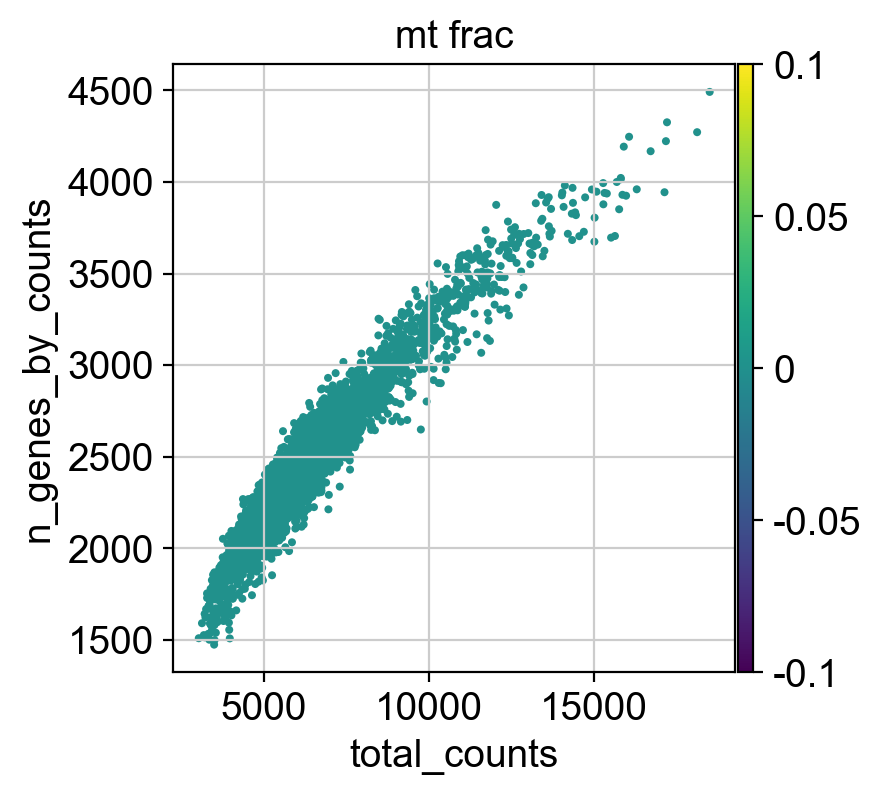

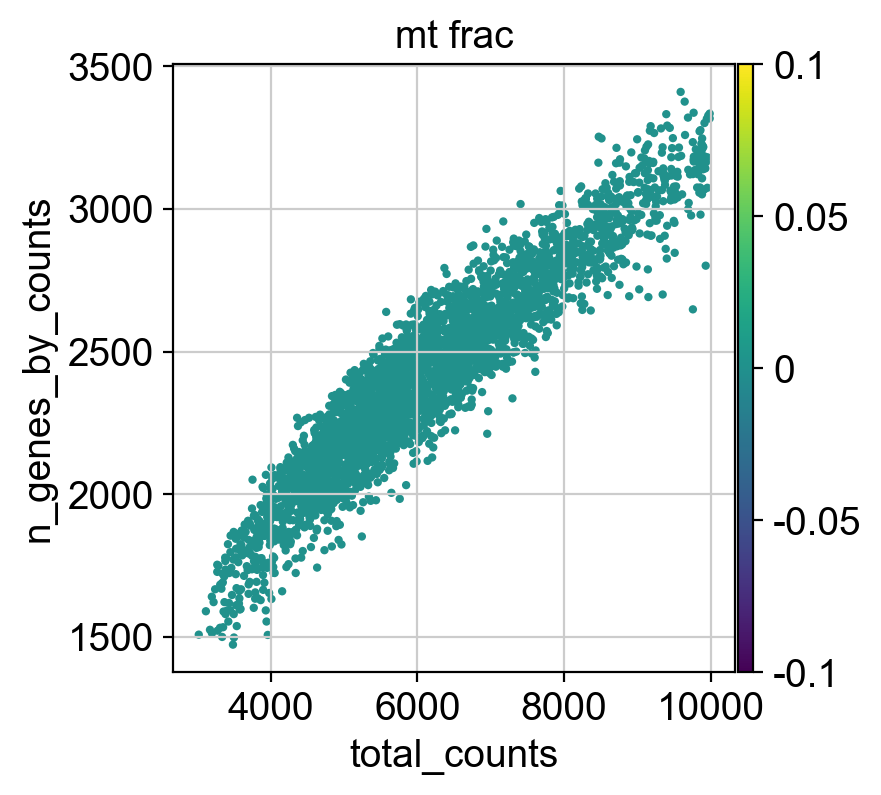

In [14]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['total_counts']<10000], 'total_counts', 'n_genes_by_counts', color='mt_frac')

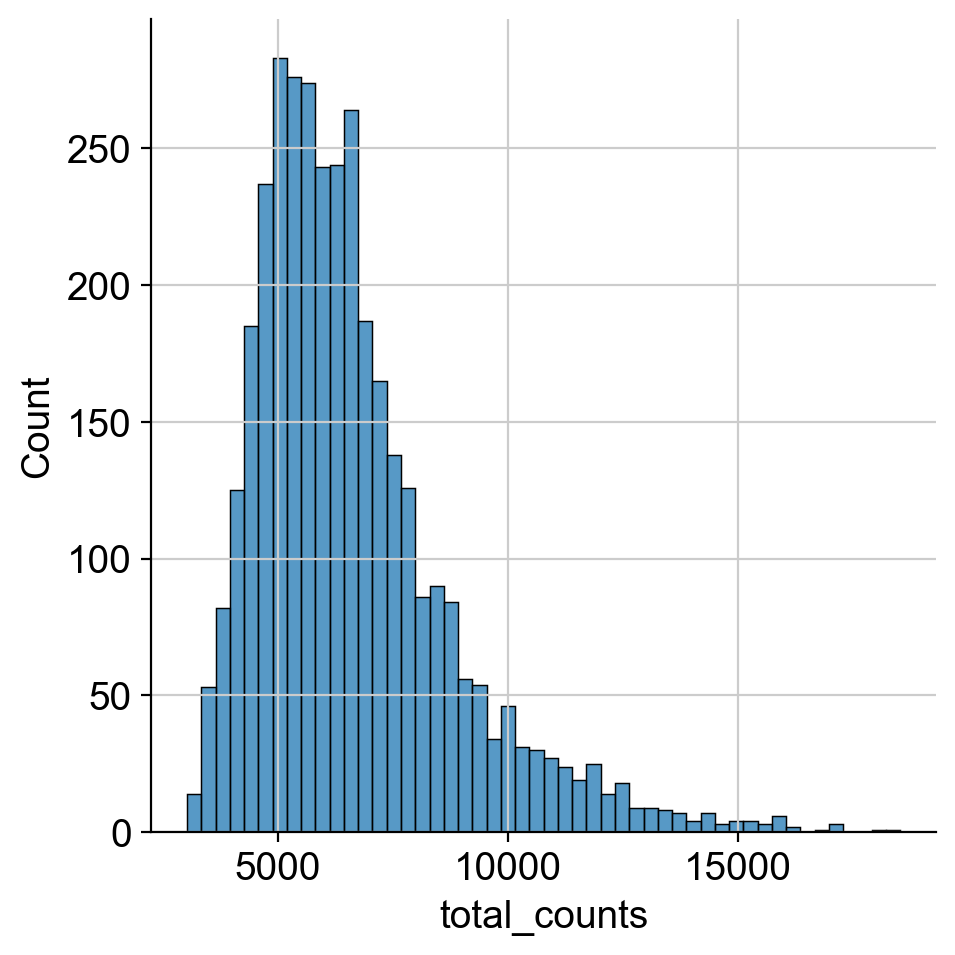

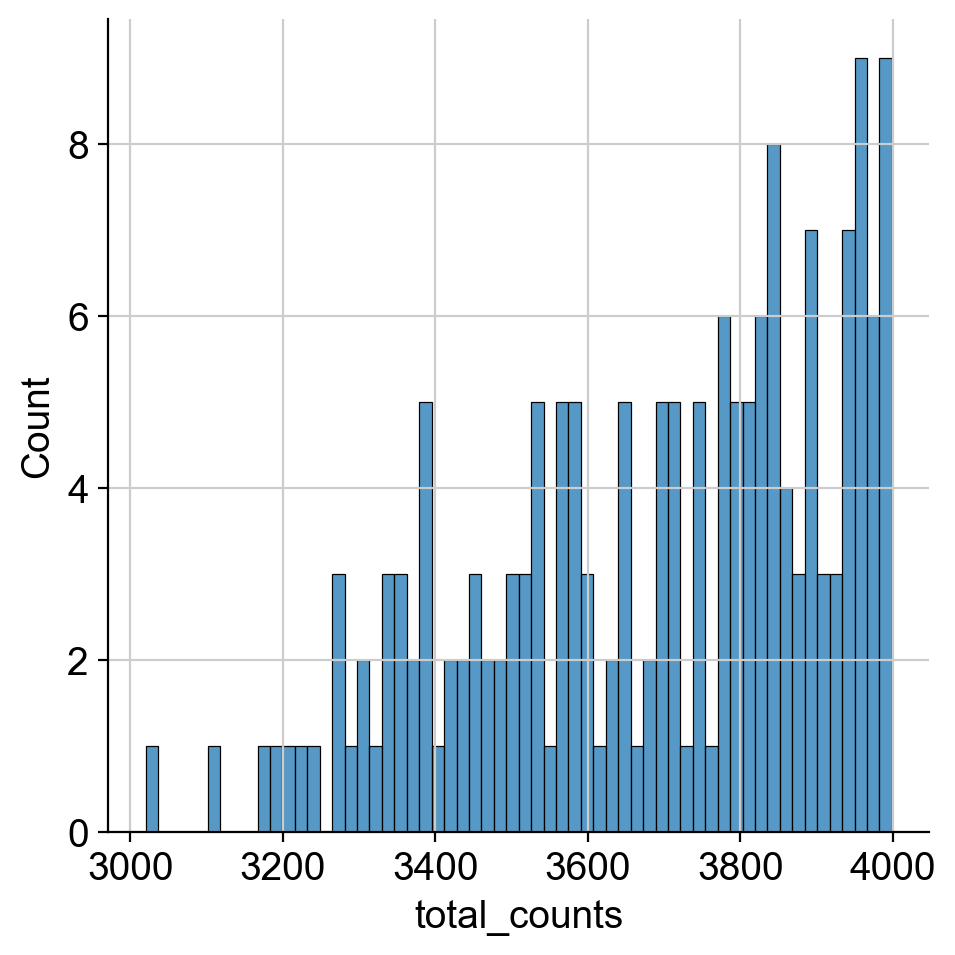

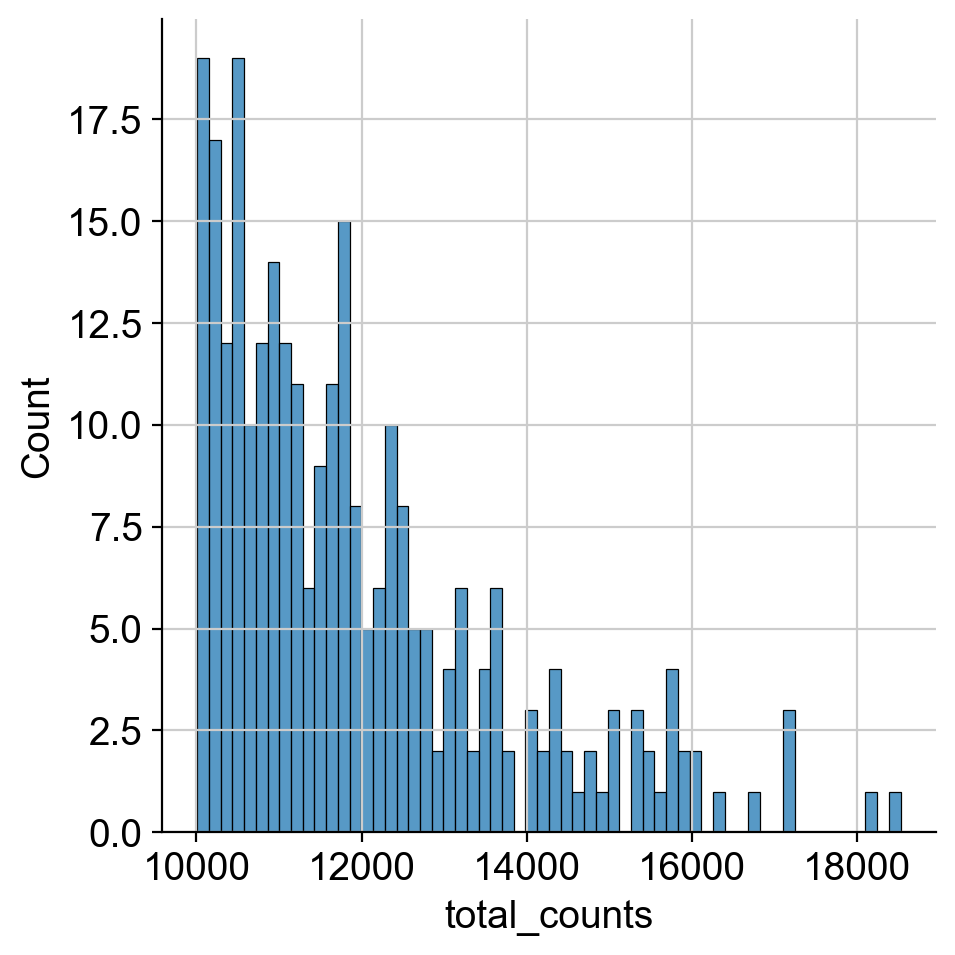

In [15]:
#Thresholding decision: counts
p3 = sns.displot(adata.obs['total_counts'])
plt.show()

p4 = sns.displot(adata.obs['total_counts'][adata.obs['total_counts']<4000], bins=60)
plt.show()

p5 = sns.displot(adata.obs['total_counts'][adata.obs['total_counts']>10000], bins=60)
plt.show()

Two populations of cells with low gene counts can be seen in the above plots. Given these plots, and the plot of genes vs counts above, we decide to filter out cells with fewer than 700 genes expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. Looking above at the joint plots, we see that we filter out the main density of low gene cells with this threshold. In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

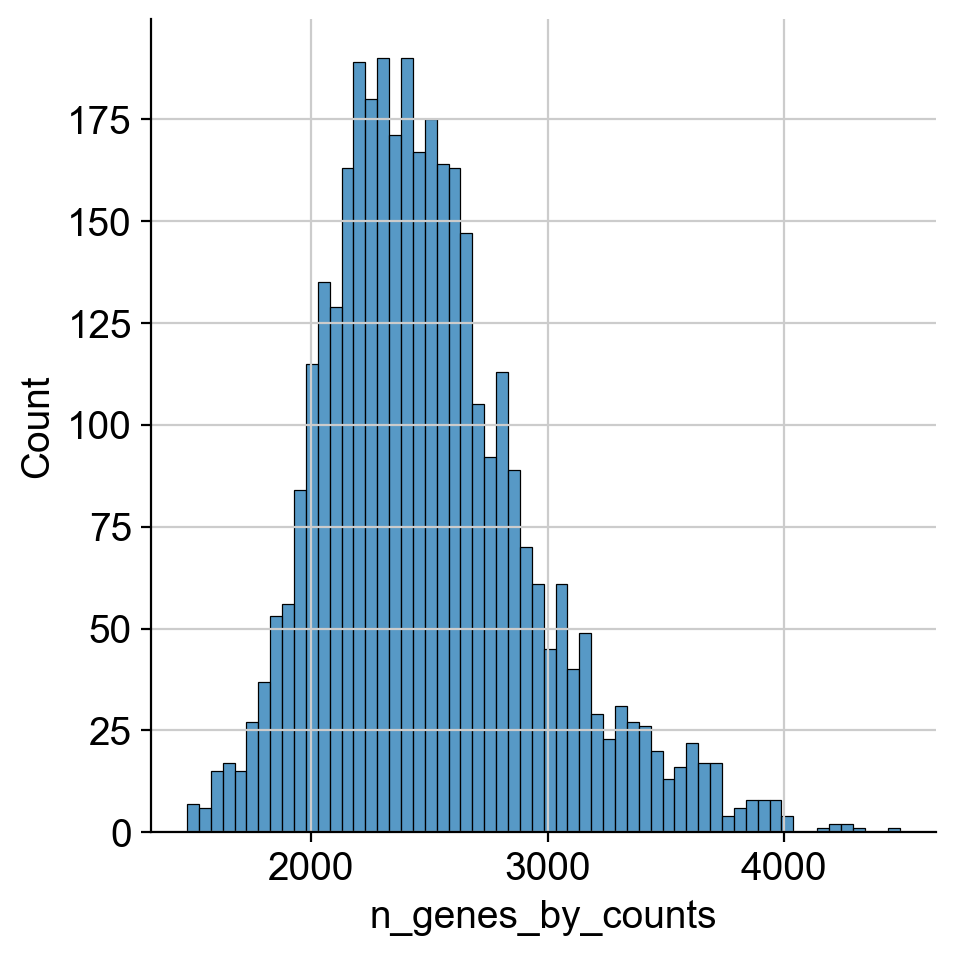

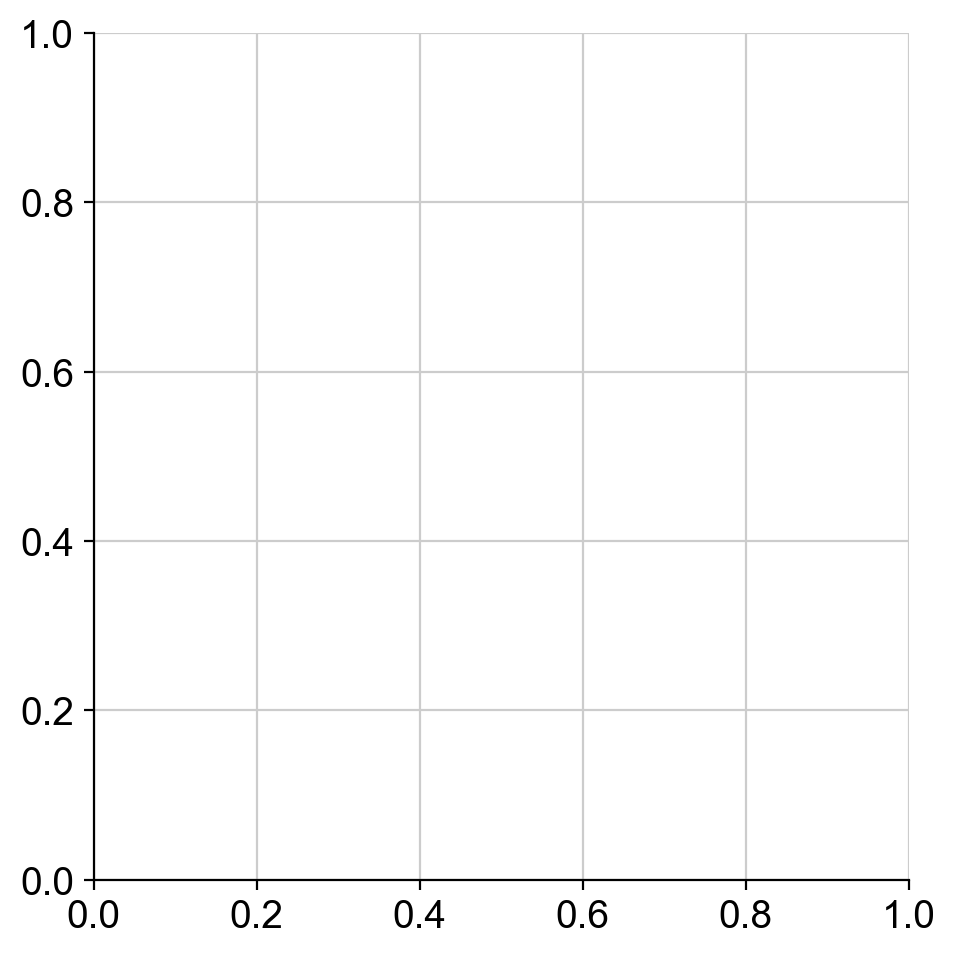

In [16]:
#Thresholding decision: genes
p6 = sns.displot(adata.obs['n_genes_by_counts'], bins=60)
plt.show()

p7 = sns.displot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<1000], bins=60)
plt.show()

In [17]:
#Filter cells:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 3606
Number of cells after min count filter: 3606
Number of cells after max count filter: 3606
Number of cells after gene filter: 3606


In [18]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 15301 genes that are detected in less than 20 cells
Number of genes after cell filter: 12697



<div class="warning" style='background-color:lightgrey; color: black; border-left: solid back 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:left'>
<b>Main take-aways</b></p>
<p style='margin-left:1em;'>

</p>
</span>
</div>

## 2.3 Normalization

Scran and sctransform normalization

- sctransform systematically outperformed other methods and, even though it was developed to be applied to data with unique molecular identifiers (UMI), it also performed fairly well with the Smart-seq protocol (Koh and Kumar datasets).

- Finally, we monitored whether, under the same downstream clustering analysis, different normalization methods tended to lead to an over- or under-estimation of the number of clusters. Although some methods had a tendency to lead to a higher (e.g., sctransform) or lower (e.g., stable genes) number of clusters, the effect was very mild and not entirely systematic (Additional File 1: Figure S16). We also confirmed that, especially in the UMI-based datasets, sctransform did in fact successfully stabilize variance across mean counts (Additional File 1: Figure S17), at little apparent cost on computation time (Additional File 1: Figure S18).

### 2.3.1 scran normalization

In [19]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Leiden clustering
    finished: found 11 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [20]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [21]:
%%R -i data_mat -i input_groups -o size_factors

#size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)
size_factors = sizeFactors(
    computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters = input_groups, min.mean=0.1)
)

In [22]:
#Delete adata_pp
del adata_pp

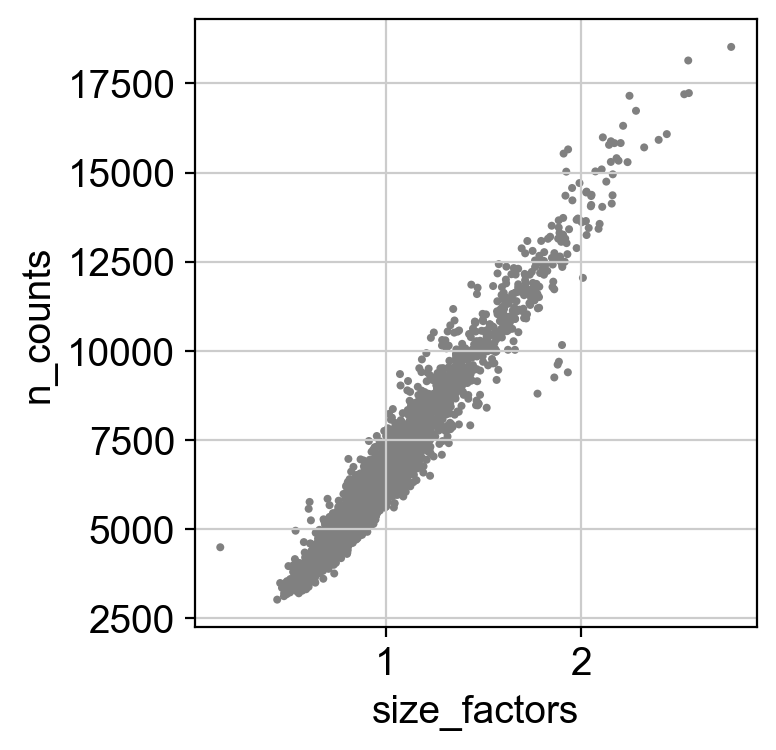

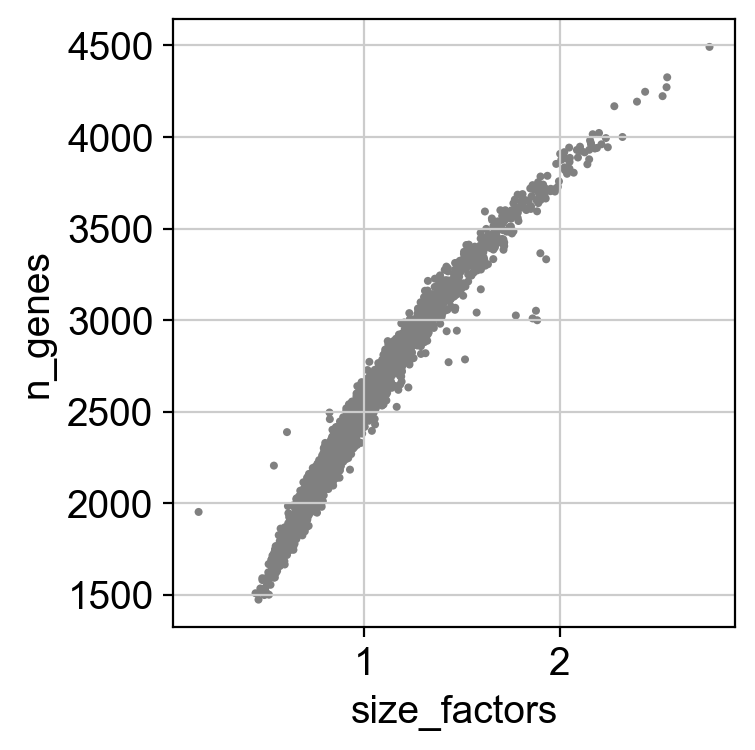

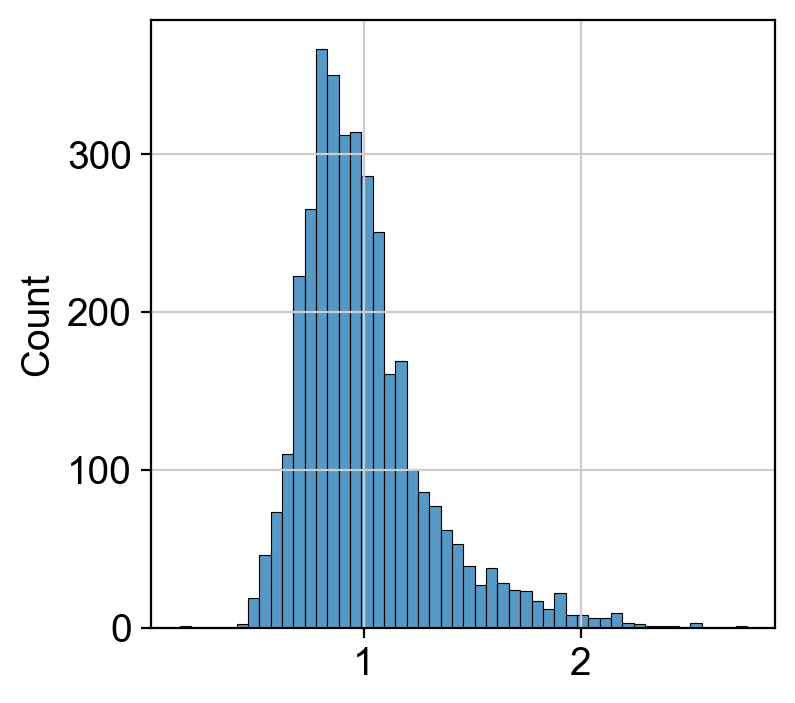

In [23]:
# Visualize the estimated size factors
adata.obs['size_factors'] = np.expand_dims(size_factors, axis=1)

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sns.histplot(size_factors, bins=50, kde=False)
plt.show()

In [24]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [25]:
#Normalize adata 
adata.layers["scran_normalized"] = adata.X / adata.obs['size_factors'].values[:,None]
adata.layers["scran_normalized_log1p"] = sc.pp.log1p(adata.layers["scran_normalized"])

### 2.3.2 sctransform normalization

In [27]:
ro.globalenv['adata'] = adata

In [28]:
%%R
seurat_obj = as.Seurat(adata, counts="X", data = NULL)
seurat_obj = RenameAssays(seurat_obj, originalexp = "RNA")
res <- SCTransform(object=seurat_obj, method = "glmGamPoi", return.only.var.genes = FALSE, do.correct.umi = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%


In [29]:
norm_x = ro.r('res@assays$SCT@scale.data').T
adata.layers['SCT_normalized_residuals'] = norm_x


<div class="warning" style='background-color:lightgrey; color: black; border-left: solid back 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:left'>
<b>Main take-aways</b></p>
<p style='margin-left:1em;'>

</p>
</span>
</div>

### 2.3.3 Log-transformation

In [31]:
sc.pp.log1p(adata)

## 2.5 Feature selection

- feature selection "should select genes whose variability is higher berween subpopulations than within"
- higher number f selected genes decreased the differences between methods
- method of choice: deviance and unstandardized estimates if variance provided best results across datasets and normalization methods
- increasing number if features selected akso tended to lead to an increase in the accuracy of the clusting, typically plateauing after 4000 features
- ranking genes by deviance operates on raw UMI counts and is not sensitive to normalization like  highly variable or highly expressed genes methods

In [32]:
%%R
sce = devianceFeatureSelection(adata, assay="counts")

In [33]:
binomial_deviance = ro.r('rowData(sce)$binomial_deviance').T

In [34]:
idx = binomial_deviance.argsort()[-4000:]
msk = np.zeros(adata.var_names.shape, dtype=bool)
msk[idx] = True

adata.var['highly_variable'] = msk
adata.uns['hvg'] = {'flavor': 'deviance'}

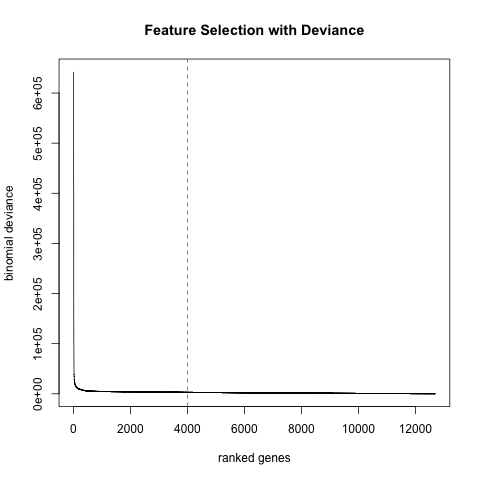

In [35]:
%%R -i binomial_deviance
#sce = devianceFeatureSelection(adata, assay="X", sorted=TRUE)
plot(sort(binomial_deviance, decreasing=TRUE), type="l", xlab="ranked genes",
     ylab="binomial deviance", main="Feature Selection with Deviance")
abline(v=4000, lty=2, col="red")


<div class="warning" style='background-color:lightgrey; color: black; border-left: solid back 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:left'>
<b>Main take-aways</b></p>
<p style='margin-left:1em;'>

</p>
</span>
</div>

## 2.5 Dimensionality reduction